# 7. Convolutional Neural Networks

## 7.1. From Fully Connected Layers to Convolutions

### 7.1.1. Invariance

When detecting objects in images, the exact location shouldn’t matter much for recognition. Drawing inspiration from the “Where’s Waldo” game, the method should recognize objects regardless of where they appear in the image. CNNs (Convolutional Neural Networks) use this idea of spatial invariance, learning useful representations with fewer parameters. 

The network architecture principles are:
1) Early layers should respond similarly to identical patterns regardless of location (translation invariance).
2) Early layers focus on local regions (locality).
3) Deeper layers capture broader features in higher-level vision.

### 7.1.2. Constraining the MLP

We can consider an MLP with two-dimensional images $X$ as inputs and their immediate hidden representations $H$, both represented as matrices. Each hidden unit receives input from all pixels using fourth-order weight tensors $W$. The fully connected layer is expressed as:


$[H]{i,j} = [U]{i,j} + \sum_k \sum_l [W]{i,j,k,l} [X]{k,l}$


This can be re-indexed as:


$[H]{i,j} = [U]{i,j} + \sum_a \sum_b [V]{i,j,a,b} [X]{i+a,j+b}$


Here, $V$ is a re-indexed version of $W$. The number of parameters for a single layer mapping a $1000 × 1000$ image to a $1000 × 1000$ hidden representation is $10^{12}$, which is far beyond current computational capabilities.

#### 7.1.2.1. Translation Invariance

By invoking translation invariance, a shift in the input $X$ results in a shift in the hidden representation $H$. This occurs when $V$ and $U$ are independent of $(i,j)$, leading to the simplified equation:


$[H]{i,j} = u + \sum_a \sum_b [V]{a,b} [X]_{i+a,j+b}$


This is a convolution! The pixels around $(i,j)$ are weighted with coefficients $[V]_{a,b}$, reducing the number of required parameters from $10^{12}$ to a more reasonable $4 \times 10^6$. The dependency now lies only on $a, b \in (-1000, 1000)$, marking a significant reduction in complexity. Time-delay neural networks (TDNNs) were among the first to utilize this approach.

#### 7.1.2.2. Locality

Invoking the second principle, locality, we assume that information far from the position $(i, j)$ should not significantly influence $H_{i,j}$. Thus, for $|a| > \Delta$ or $|b| > \Delta , we set $V_{a,b} = 0$, simplifying the equation to:


$[H]{i,j} = u + \sum{a=-\Delta}^{\Delta} \sum_{b=-\Delta}^{\Delta} [V]{a,b} [X]{i+a,j+b}$


This reduces the number of parameters from $4 \times 10^6$ to $4 \Delta^2$, where $\Delta $is typically less than 10, creating a convolutional layer. CNNs, which consist of such convolutional layers, use $V$ as a convolution kernel or filter. The result is a significant reduction in parameters, but this introduces a reliance on translation invariance. If the bias induced by this invariance does not align with reality, the model might struggle to fit the data. Nevertheless, deeper layers can represent more complex aspects of an image by interleaving non-linearities and convolutional layers.

### 7.1.3. Convolutions

Section 7.1.2.2.'s equation is called a convolution. In mathematics, the convolution of two functions $f$ and $g$, denoted as $(f * g)(x)$, is defined as:


$(f * g)(x) = \int f(z) g(x - z) dz$.


This measures the overlap between $f$ and $g$ when one function is “flipped” and shifted by $x$. For discrete vectors, this becomes a sum:


$(f * g)(i) = \sum_a f(a) g(i - a)$.


For two-dimensional tensors, this sum extends to indices $(a, b)$ for $f$ and $(i - a, j - b)$ for $g$:


$(f * g)(i, j) = \sum_a \sum_b f(a, b) g(i - a, j - b)$.


This closely resembles equation, except instead of using $(i + a, j + b)$, we use the difference terms $(i - a, j - b) . However, this distinction is mainly cosmetic, as both definitions can be adjusted to match each other. Equation is more accurately described as cross-correlation, a topic that will be discussed in the following section.

### 7.1.4. Channels

Returning to the Waldo detector, the convolutional layer selects windows based on the filter $V$, and wherever the “waldoness” is highest, we should find a peak in the hidden layer representations. However, this approach overlooks the fact that images have three channels: red, green, and blue, meaning that images are third-order tensors with dimensions such as $1024 \times 1024 \times 3$.

To adapt to this, the convolutional layer now uses  V_{a,b,c,d} , with an additional coordinate  d  for the output channels in the hidden representations  H . The new equation becomes:


$[H]{i,j,d} = \sum{a=-\Delta}^{\Delta} \sum_{b=-\Delta}^{\Delta} \sum_{c} [V]{a,b,c,d} [X]{i+a,j+b,c}$


Here, $d$ indexes the output channels in the hidden representations. The next step is to combine multiple layers to detect whether Waldo exists anywhere in the image. This leads to further decisions on how to efficiently handle multiple layers and activations, discussed later in the chapter.

### 7.1.5. Summary and Discussion

In this section, we derived the structure of CNNs from first principles. Translation invariance in images implies that all patches of an image are treated similarly, and locality ensures that only nearby pixels are used to compute hidden representations. Early references to CNNs include the Neocognitron (Fukushima, 1982).

The second principle is reducing the number of parameters without limiting the model’s expressive power, which simplifies previously infeasible problems into manageable models. Adding channels, such as in hyperspectral satellite imagery, restored some complexity lost due to locality and translation invariance. This approach is natural for multi-channel data beyond just RGB. The upcoming sections will explore how to use convolutions to manipulate image dimensionality and deal with large numbers of categories efficiently.

## 7.2. Convolutions for images

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

### 7.2.1. The Cross-Correlation Operation

In [2]:
def corr2d(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 7.2.2. Convolutional Layers

In [4]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

### 7.2.3. Object Edge Detection in Images

In [5]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [6]:
K = torch.tensor([[1.0, -1.0]])

In [7]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [8]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### 7.2.4. Learning a Kernel

In [9]:
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 12.122
epoch 4, loss 2.714
epoch 6, loss 0.734
epoch 8, loss 0.237
epoch 10, loss 0.087


/Users/hanjaehoon/Library/Mobile Documents/com~apple~CloudDocs/Korea Univ./2024 Fall/Deep Learning/hw2/.venv/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [10]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0132, -0.9551]])

### 7.2.5. Cross-Correlation and Convolution

From Section 7.1, we observed the relationship between cross-correlation and convolution operations.

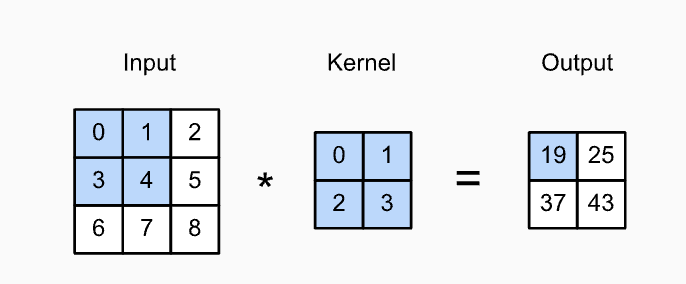 Fig. 7.2.1

It is important to note that since kernels in deep learning are learned from data, the outputs of convolutional layers remain the same whether the layers perform strict convolution or cross-correlation. For example, if a convolutional layer learns the kernel $K$ in Fig. 7.2.1 and performs strict convolution, flipping the kernel will produce the same output as the cross-correlation.

We continue to use the term “convolution” in the deep learning context, even though, technically, we refer to cross-correlation. The term “element” refers to any entry of a tensor representing a layer’s output or a convolution kernel.

### 7.2.6. Feature Map and Receptive Field

As described in Section 7.1.4, the convolutional layer output in Fig. 7.2.1 is called a feature map. The receptive field of an element $x$ in some layer refers to all the elements that affect the calculation of $x$, and it may be larger than the input’s actual size.

Using Fig. 7.2.1, the receptive field of the shaded output element (value 19) is the four shaded elements of the input. For a deeper CNN with another 2 × 2 convolutional layer, the receptive field for an element $z$ on $Y$ includes all input elements, allowing the network to detect broader features.

The concept of receptive fields originates from neurophysiology, particularly experiments by Hubel and Wiesel, which found that lower levels respond to edges and shapes. Field (1987) later showed this effect on natural images using convolutional kernels, as illustrated in Fig. 7.2.2. These insights help explain the success of deep learning, especially in image classification tasks.

### 7.2.7. Summary

The core computation for a convolutional layer is a cross-correlation operation. With multiple input and output channels, the operation becomes a matrix–matrix computation between channels. This process is highly local, allowing for significant hardware optimizations. This locality allows chip designers to focus on fast computation rather than memory, enabling more accessible and affordable computer vision solutions.

Convolutions serve various purposes, such as detecting edges, blurring, or sharpening images. Importantly, filters do not need to be manually designed; they can be learned from data, which replaces traditional feature engineering. These learned filters correspond to receptive fields and feature maps, not only in neural networks but also in the brain, providing confidence in the direction of deep learning research.

### 7.2.8. Exercises

## 7.3. Padding and Stride

In [11]:
import torch
from torch import nn

### 7.3.1. Padding

In [12]:
def comp_conv2d(conv2d, X):
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    return Y.reshape(Y.shape[2:])

conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [13]:
conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

### 7.3.2. Stride

In [14]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [15]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

### 7.3.3. Summary and Discussion

Padding is used to increase the height and width of the output, ensuring that the output size remains the same as the input size and that all pixels are treated equally. Typically, symmetric padding is applied to both the height and width of the input, referred to as $(p_h, p_w)$, or simply $p$ when both are equal.

Strides, represented by $s_h$ (horizontal) and $s_w$ (vertical), similarly affect the output. When strides are equal, we refer to stride $s$, which reduces the resolution of the output by a factor of $1/n$ for $n > 1$. By default, padding is set to 0 and stride to 1.

Padding usually adds zeros around the image, which is computationally efficient. This allows CNNs to implicitly learn positional information by determining the “whitespace.” Various alternatives to zero-padding exist, but Alsallakh et al. (2020) reviewed these options without concluding when nonzero paddings should be used.

## 7.4. Multiple Input and Multiple Output Channels

In [16]:
import torch
from d2l import torch as d2l

### 7.4.1. Multiple Input Channels

In [17]:
def corr2d_multi_in(X, K):
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [18]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

### 7.4.2. Multiple Output Channels

In [19]:
def corr2d_multi_in_out(X, K):
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [20]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [21]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

### 7.4.3. $1 \times 1$ Convolutional Layer

In [22]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [23]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

### 7.4.4. Discussion

Channels enable us to combine the advantages of MLPs, which introduce significant nonlinearities, and convolutions, which allow localized feature analysis. Channels allow CNNs to process multiple features, such as edge and shape detectors, simultaneously. They offer a practical trade-off between reducing parameters, thanks to translation invariance and locality, and the need for expressive, diverse models.

However, this flexibility comes with a cost. For an image of size $h \times w$, the computational cost of a $k \times k$ convolution is $O(h \cdot w \cdot k^2)$. For $c_i$ input channels and $c_o$ output channels, the cost increases to $O(h \cdot w \cdot k^2 \cdot c_i \cdot c_o)$. For example, a $256 × 256$ pixel image with a $5 × 5$ kernel and 128 input and output channels results in over 53 billion operations. Methods like block-diagonal operations, as used in architectures such as ResNeXt (Xie et al., 2017), are introduced to reduce this computational burden.

## 7.5. Pooling

In [24]:
import torch
from torch import nn
from d2l import torch as d2l

### 7.5.1. Maximum Pooling and Average Pooling

In [25]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [26]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [27]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

### 7.5.2. Padding and Stride

In [28]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [29]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [30]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [31]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

### 7.5.3. Multiple Channels

In [32]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [33]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

### 7.5.4. Summary

Pooling is a simple operation that aggregates values over a window, such as $2 \times 2$. It applies equally to all channels without changing the number of channels and operates independently on each channel. Among popular pooling methods, max-pooling is preferred over average pooling due to its ability to preserve invariance in the output.

Other methods of reducing resolution include stochastic pooling (Zeiler and Fergus, 2013), which introduces randomization, and fractional max-pooling (Graham, 2014), which can slightly improve accuracy. Future sections will introduce more sophisticated aggregation methods, such as attention mechanisms, that align outputs based on query and representation vectors.

## 7.6. Convolutional Neural Networks (LeNet)

In [34]:
import torch
from torch import nn
from d2l import torch as d2l

### 7.6.1. LeNet

In [35]:
def init_cnn(module):
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [36]:
@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


### 7.6.2. Training

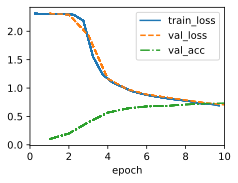

In [37]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

### 7.6.3. Summary

In this chapter, we explored the transition from MLPs in the 1980s to CNNs in the 1990s and 2000s. LeNet-5 remains relevant even today. By comparing error rates on Fashion-MNIST, we can see that LeNet-5 performs much better than MLPs but is still not as advanced as modern architectures like ResNet. One key difference is that greater computational power enabled more complex architectures like LeNet.

Another significant difference is the ease with which LeNet can now be implemented. What once required months of coding and tool development can now be done in minutes, thanks to modern deep learning tools and frameworks. This efficiency has democratized deep learning model development. In the next chapter, we will explore further advancements in this field.

# 8. Modern Convolutional Neural Networks

## 8.2. Networks Using Blocks (VGG)

In [38]:
import torch
from torch import nn
from d2l import torch as d2l

### 8.2.1. VGG Blocks

In [39]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

### 8.2.2. VGG Network

In [40]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [41]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


### 8.2.3. Training

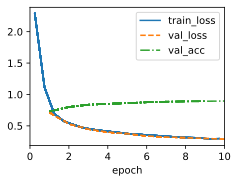

In [42]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

### 8.2.4. Summary

VGG is often considered the first truly modern convolutional neural network (CNN). While AlexNet introduced key components for deep learning at scale, VGG emphasized using blocks of multiple convolutions and a preference for deep, narrow networks. VGG also represented a family of similarly parameterized models, allowing a balance between complexity and speed. Modern deep learning frameworks, such as Python-based tools, have made it easier to assemble networks without needing XML configuration files.

More recently, ParNet (Goyal et al., 2021) demonstrated that competitive performance can be achieved with a much shallower architecture, relying on parallel computations. This approach opens up possibilities for influencing future neural network designs, continuing the progress made over the past decade in deep learning.

## 8.6. Residual Networks (ResNet) and ResNeXt

In [43]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

### 8.6.1. Function Classes

The class of functions $\mathcal{F}$ defines what a specific network architecture can achieve. We aim to find the best possible approximation of the “truth” function $f^*$ within $\mathcal{F}$. The goal is to minimize the loss $L(X, y, f)$ by optimizing over $\mathcal{F}$. However, more complex models do not always guarantee a better approximation of $f^*$, especially for non-nested function classes, as shown in Fig. 8.6.1. Increasing complexity can sometimes push the model further from $f^*$.

In contrast, nested function classes ensure that larger classes contain smaller ones, which allows for more expressive models. This idea underpins the success of deep neural networks. For example, ResNet (He et al., 2016) introduced residual blocks, allowing the identity function $f(x) = x$ to be incorporated, ensuring that deeper layers do not degrade performance. This concept became foundational in designing modern deep networks, influencing models like Transformers (Vaswani et al., 2017) and graph neural networks (Kipf and Welling, 2016).

### 8.6.2. Residual Blocks

In [44]:
class Residual(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [45]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

In [46]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

### 8.6.3. ResNet Model

In [47]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [48]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [49]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [50]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


### 8.6.4. Training

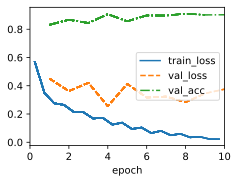

In [51]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)